This is a **Keras** implementation of an **image classifier** following this [blog post](http://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html).
<br>
The data comes from the following [Kaggle challenge](https://www.kaggle.com/c/dogs-vs-cats/data)

Notice that you will need to install the requirements in the `requirements.txt` file by running: <br>
    `pip install -r requirements.txt`

In [2]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
import pandas as pd
import numpy as np
import h5py

## Images preprocessing

In [3]:
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

### An example of an image transformation for data augmentation

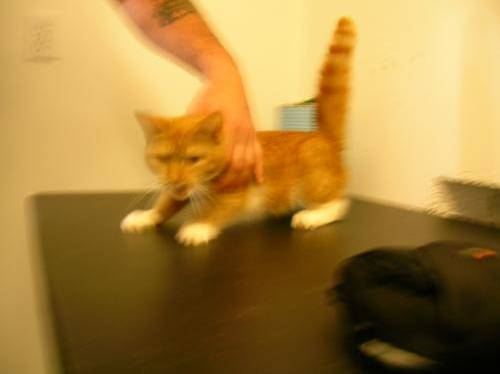

In [4]:
img = load_img('data/train/cats/cat.0.jpg')  # this is a PIL image
img

In [7]:
x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
i = 0
for batch in datagen.flow(x, batch_size=1,
                          save_to_dir='preview', save_prefix='cat', save_format='jpeg'):
    i += 1
    if i > 20:
        break  # otherwise the generator would loop indefinitely

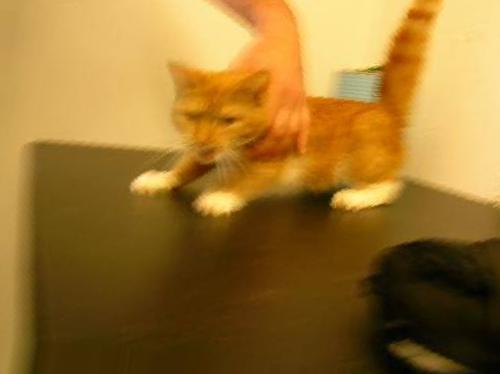

In [9]:
transformed_img = load_img('preview/cat_0_1558.jpeg')  # this is a transformed cat image
transformed_img

## Building the model

In [10]:
model = Sequential()
model.add(Convolution2D(32, 3, 3, input_shape=(3, 150, 150)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(32, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(64, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# the model so far outputs 3D feature maps (height, width, features)
model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

## Compiling the model


In [11]:
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

## Train and test pipelines

In [12]:
# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        'data/train',  # this is the target directory
        target_size=(150, 150),  # all images will be resized to 150x150
        batch_size=32,
        class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        'data/validation',
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

Found 13500 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


## Fit the model

In [13]:
model.fit_generator(
        train_generator,
        samples_per_epoch=2000,
        nb_epoch=50,
        validation_data=validation_generator,
        nb_val_samples=800)

Epoch 1/50
1984/2000 [============================>.] - ETA: 1s - loss: 0.3427 - acc: 0.9148

/home/yassine/Envs/deep-learning/lib/python3.4/site-packages/keras/engine/training.py:1403: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


2016/2000 [==============================] - 254s - loss: 0.3443 - acc: 0.9137 - val_loss: 0.9962 - val_acc: 0.5000
Epoch 2/50
2016/2000 [==============================] - 217s - loss: 0.2823 - acc: 0.9276 - val_loss: 1.3767 - val_acc: 0.5000
Epoch 3/50
2016/2000 [==============================] - 214s - loss: 0.2944 - acc: 0.9201 - val_loss: 1.0016 - val_acc: 0.5000
Epoch 4/50
2016/2000 [==============================] - 218s - loss: 0.2620 - acc: 0.9335 - val_loss: 1.5635 - val_acc: 0.5000
Epoch 5/50
2016/2000 [==============================] - 218s - loss: 0.2881 - acc: 0.9256 - val_loss: 1.0156 - val_acc: 0.5000
Epoch 6/50
2016/2000 [==============================] - 216s - loss: 0.2847 - acc: 0.9226 - val_loss: 0.9464 - val_acc: 0.5000
Epoch 7/50
2012/2000 [==============================] - 270s - loss: 0.2761 - acc: 0.9269 - val_loss: 1.0659 - val_acc: 0.5000
Epoch 8/50
2016/2000 [==============================] - 251s - loss: 0.2829 - acc: 0.9296 - val_loss: 1.3038 - val_acc: 0.

In [15]:
model.save_weights('first_try.h5', overwrite=True)  # always save your weights after training or during training

## Use the fitted model

### Save the model architecture 

In [19]:
saved_model = model.to_json()
import json
with open('model_architecture.json', 'w') as outfile:
    json.dump(saved_model, outfile)

### Load the model (if not already)

In [28]:
from keras.models import model_from_json
loaded_model = model_from_json(json.load(open('model_architecture.json', 'r')))

In [16]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 32, 148, 148)  896         convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 32, 148, 148)  0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 32, 74, 74)    0           activation_1[0][0]               
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 32, 72, 72)    9248        maxpooling2d_1[0][0]             
___________________________________________________________________________________________

### Make some predictions

In [44]:
train_score = model.evaluate_generator(train_generator, 100)
validation_score = model.evaluate_generator(validation_generator, 100)

In [45]:
train_score, validation_score

([0.17862831056118011, 0.9453125], [1.6027434468269348, 0.5])

In [160]:
def load_images(_class='cats'):
    images = np.ndarray(shape=(32, 3, 150, 150))
    for index, img_index in enumerate(range(1000, 1032)):
        if _class == 'cats':
            base_path = 'data/validation/cats/cat.'
        else:
            base_path = 'data/validation/dogs/dog.'
        image = img_to_array(load_img(base_path + str(img_index) + '.jpg'))
        try:
            images[index] = image[:, :, :] / 255
        except ValueError:
            pass
    return images

In [161]:
test_cat_images = load_images()
test_dog_images = load_images(_class='dogs')

In [169]:
(img_to_array(load_img('data/validation/cats/cat.1003.jpg')) / 255).shape

(3, 269, 259)

In [157]:
cat_predictions = model.predict(test_cat_images)
dog_predictions = model.predict(test_dog_images)

In [89]:
model.predict_generator(validation_generator, 32)

array([[ 0.99288434],
       [ 0.96230644],
       [ 0.93783188],
       [ 0.96077663],
       [ 0.99993837],
       [ 0.921547  ],
       [ 0.98548347],
       [ 0.9766593 ],
       [ 0.92833465],
       [ 0.99372214],
       [ 0.95198524],
       [ 0.90722746],
       [ 0.9975298 ],
       [ 0.96643299],
       [ 0.99438506],
       [ 0.95341653],
       [ 0.99770129],
       [ 0.98410881],
       [ 0.98958117],
       [ 0.96347207],
       [ 0.99843132],
       [ 0.88893694],
       [ 0.89580613],
       [ 0.99032712],
       [ 0.90973639],
       [ 0.98974431],
       [ 0.88533753],
       [ 0.9580664 ],
       [ 0.89673609],
       [ 0.98038614],
       [ 0.99456418],
       [ 0.97698373]])